# Deforestation in the Amazon

### Use Sentinel Hub data https://www.sentinel-hub.com/ . Compare 2017 and 2019 NDVI (normalized difference vegetation index) data to estimate the rate of deforestation.

In [ ]:
### Start with a map of the study location in the Amazon. A sample of land on the margin of the forest and frontier settlments, also affected by 2019 fires

psconvert [ERROR]: Error opening HKLM key


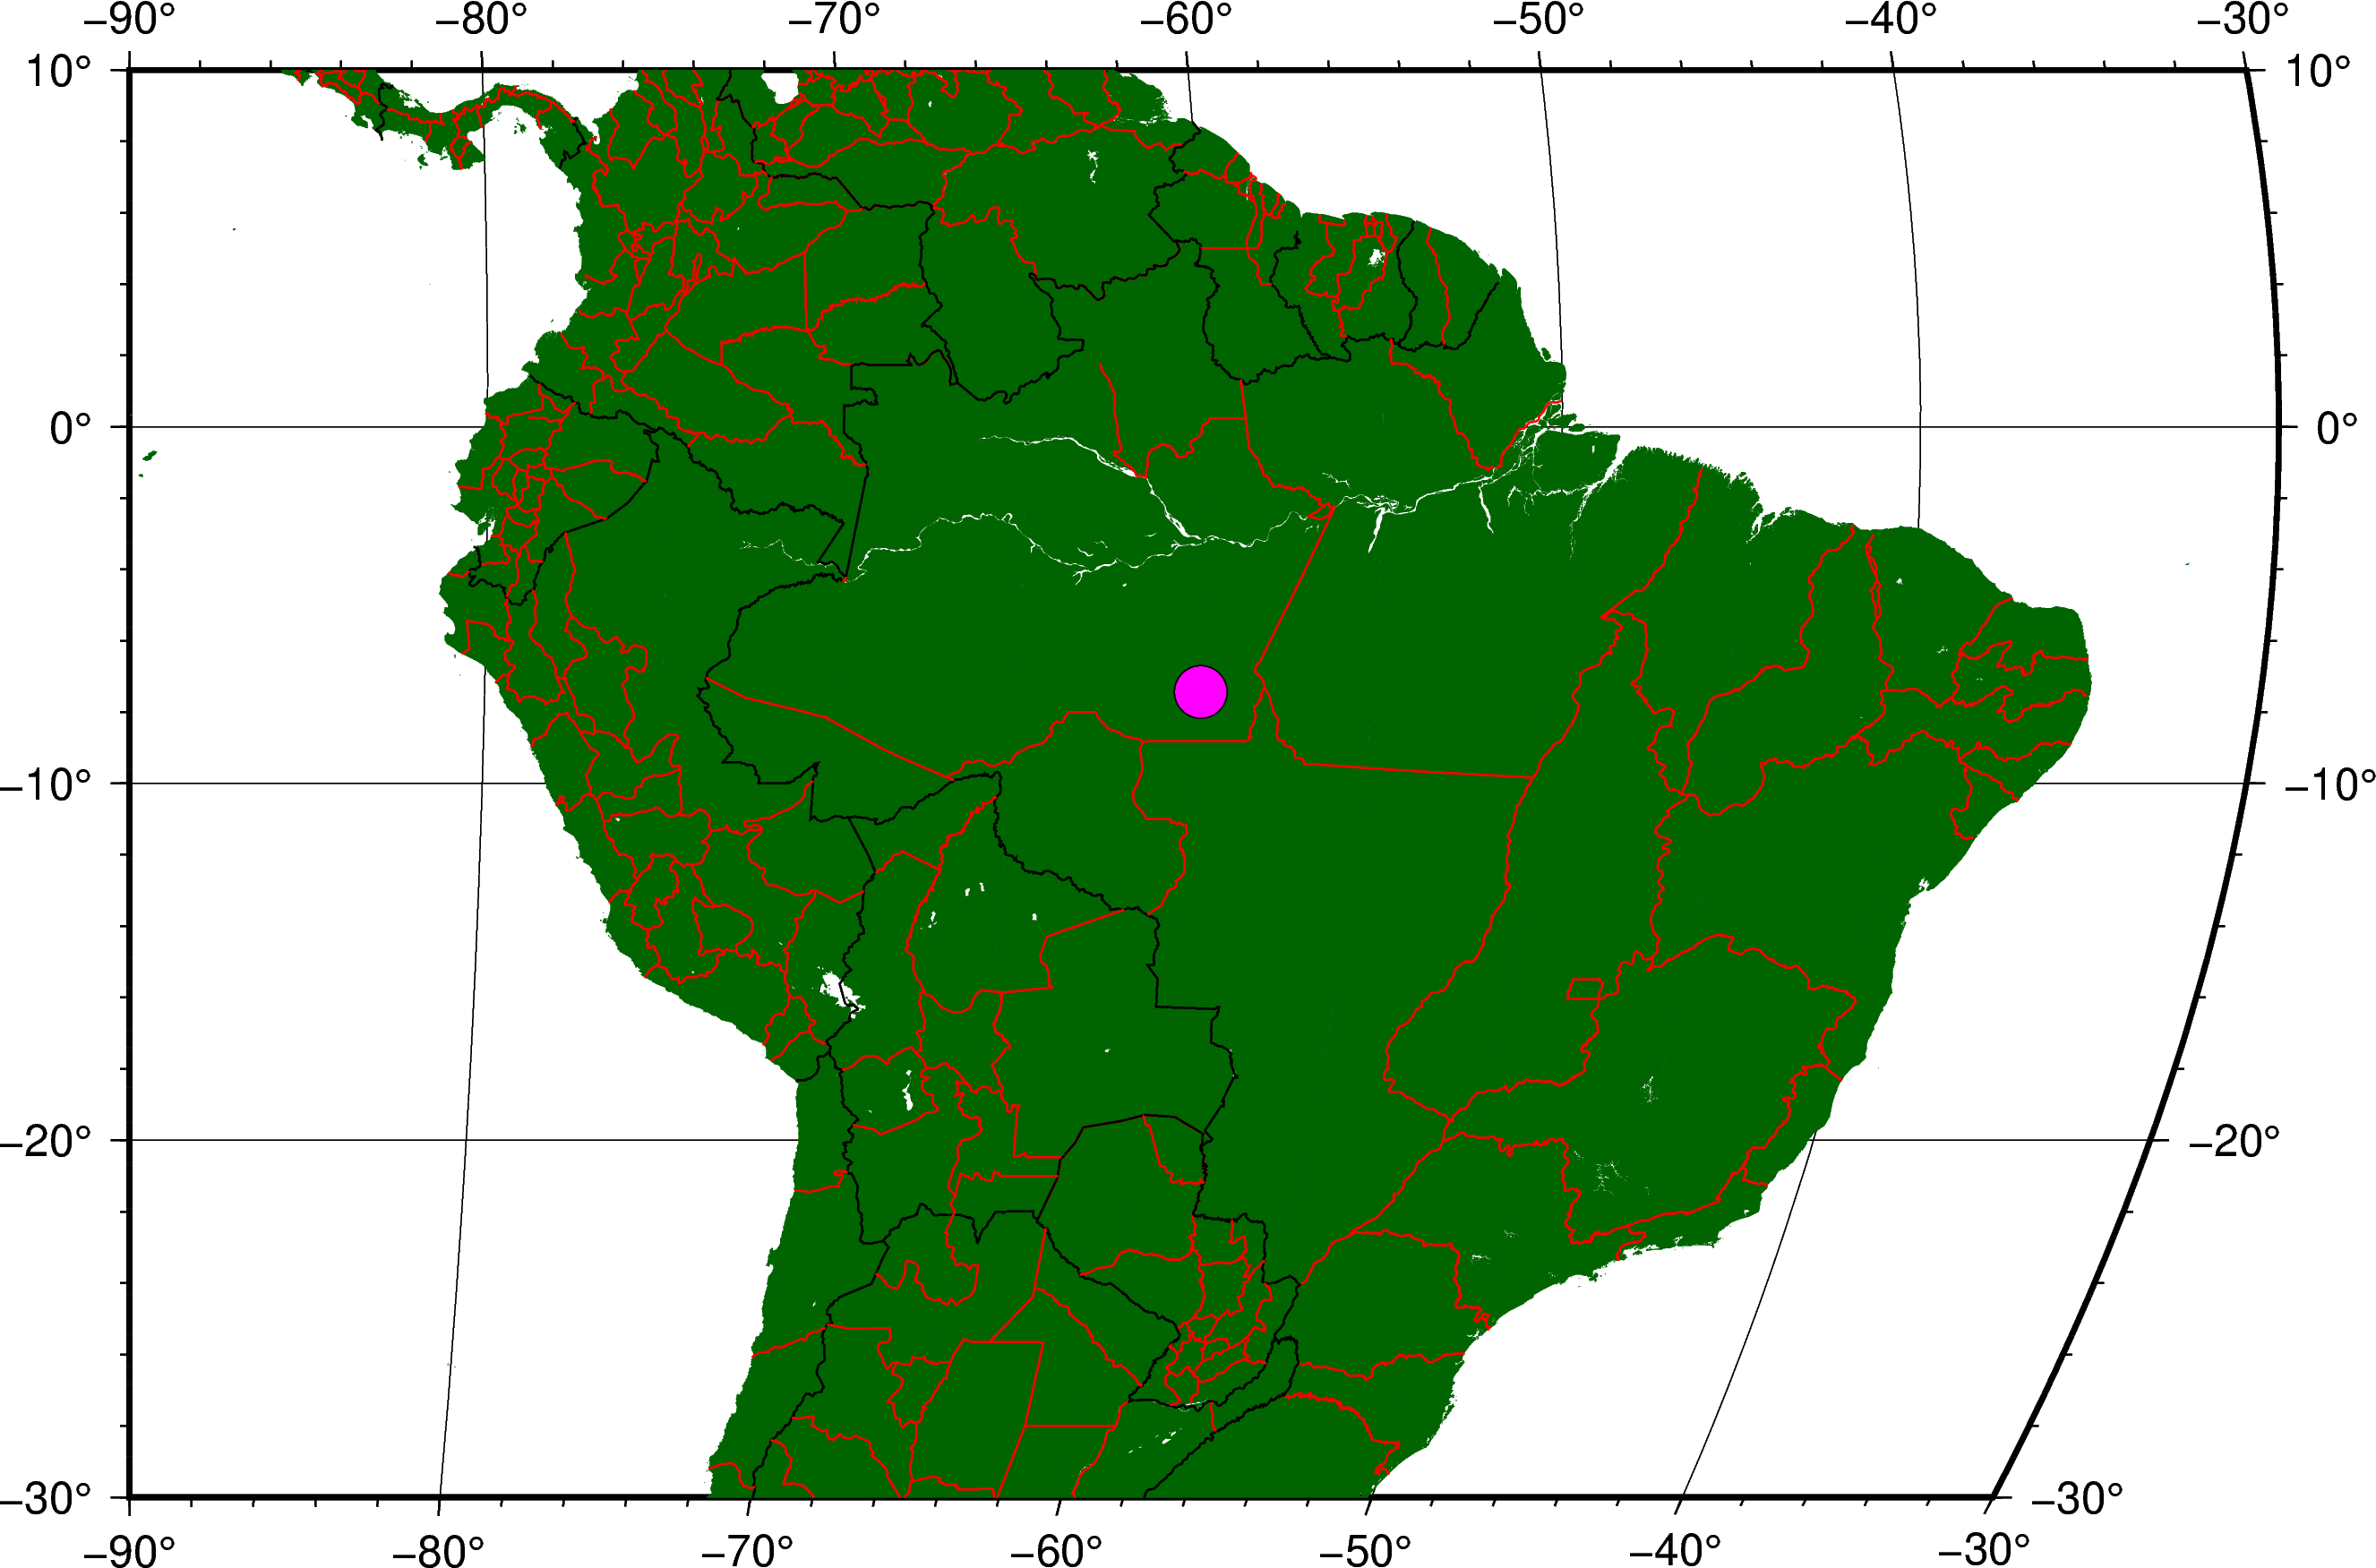

In [2]:
import pygmt

forest_coords= [-7.440488, -59.840237]

fig = pygmt.Figure()
# Make a Sinusoidal projection map of the Americas with automatic ticks
fig.basemap(region=[-90, -30, -30, 10], projection="I-90/8i", frame="afg")
# Plot each level of the boundaries dataset with a different color.
fig.coast(borders=["1/0.5p,black", "2/0.5p,red", "3/0.5p,blue"], land="darkgreen")
fig.plot(x= forest_coords[1], y= forest_coords[0], style="c0.5c", color="magenta", pen="black")
fig.show()

#### Provide Sentinel Hub credentials, load packages, define a raster plotting function, and the geographic coordinates and area for the investigation.

In [16]:
from sentinelhub import SHConfig


INSTANCE_ID = ''  # In case you put instance ID into configuration file you can leave this unchanged

if INSTANCE_ID:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
else:
    config = None
    
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox

def plot_image(image, factor=1, colmap='viridis'):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1), cmap = colmap)
    else:
        plt.imshow(image, cmap = colmap )
        
        
bbox =  [forest_coords[1]-0.06, 
         forest_coords[0]-0.06, 
         forest_coords[1]+0.06,
         forest_coords[0]+0.06]

forest_bbox = BBox(bbox=bbox, crs=CRS.WGS84)

#### Take NDVI data from the 2017 dry season on the edge of the Amazon rainforest.

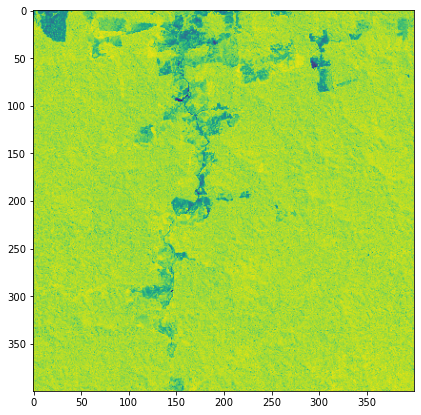

In [17]:
 wms_true_color_request = WmsRequest(
       # layer='TRUE-COLOR-S2-L1C',
        layer='NDVI',
        bbox=forest_bbox,
        time= '2017-07-07',
        width=400,
        height=400,
        config=config
    )
    
wms_true_color_img = wms_true_color_request.get_data()
ndvi2017=wms_true_color_img[-1]
plot_image(wms_true_color_img[-1])


#### Take NDVI data from the 2019 dry season on the edge of the Amazon rainforest.

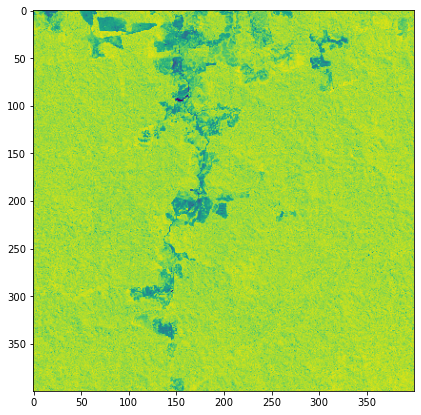

In [18]:
    wms_true_color_request = WmsRequest(
       # layer='TRUE-COLOR-S2-L1C',
        layer='NDVI',
        bbox=forest_bbox,
        time= '2019-07-12',
        width=400,
        height=400,
        config=config
    )
    
    

wms_true_color_img = wms_true_color_request.get_data()
ndvi2019=wms_true_color_img[-1]
plot_image(wms_true_color_img[-1])

#### Subtract the 2019 data from the 2017 data to see where the forest has been cleared vs. where it has regrown.

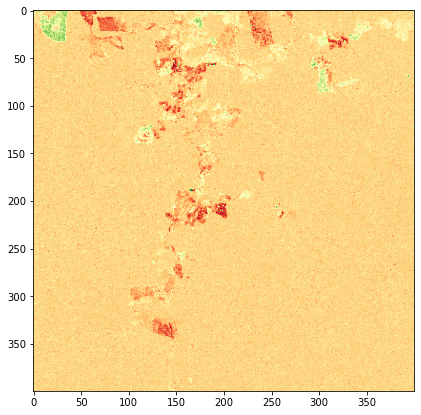

In [19]:
import matplotlib
ndviloss = np.subtract(ndvi2017, ndvi2019)
flatten = lambda l: [item for sublist in l for item in sublist]
flatten(ndviloss)
ndviloss = np.reshape(flatten(ndviloss), (400, 400))
plot_image((ndviloss-100), colmap = matplotlib.cm.get_cmap('RdYlGn_r')) # subtract 100 for contrast

#### Make the regions of deforestation and regrowth bolder for conversion to shapefile or KML format.

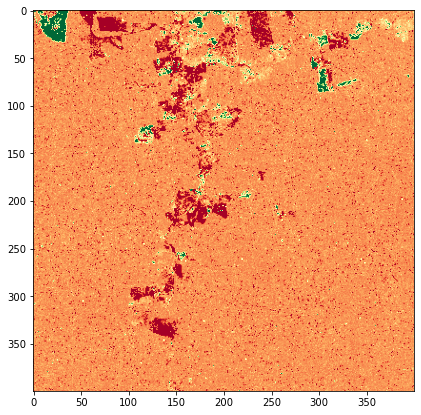

In [20]:
ndviloss = np.subtract(ndvi2017, ndvi2019)
ndviloss = ndviloss-100
ndviloss[ndviloss < 125] = 0
ndviloss[(125 > ndviloss) & (ndviloss < 170)] = 40
ndviloss[ndviloss > 170] = 200
plot_image((ndviloss), colmap = matplotlib.cm.get_cmap('RdYlGn_r')) # make solid colors for shapefile and raster

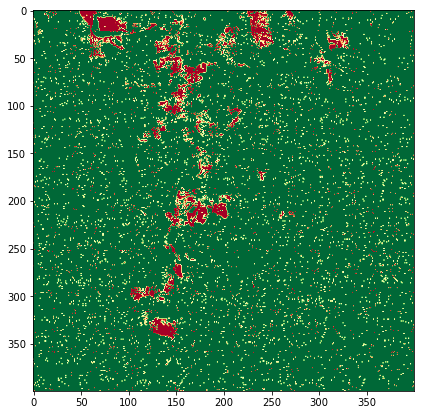

In [21]:

ndviloss = np.subtract(ndvi2017, ndvi2019)
ndviloss = ndviloss-100
ndviloss[ndviloss > 170] = 200
ndviloss[ndviloss < 170] = 0
plot_image((ndviloss), colmap = matplotlib.cm.get_cmap('RdYlGn_r')) # make solid colors for shapefile and raster


#### Use two tone to show only areas of regrowth.

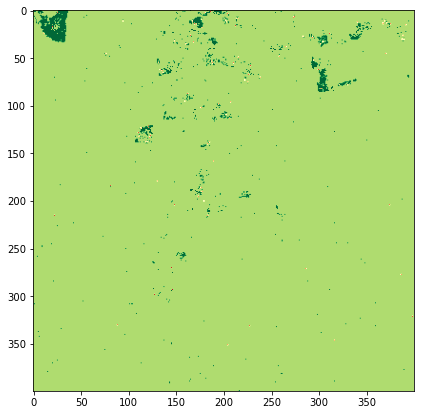

In [22]:
ndviloss = np.subtract(ndvi2017, ndvi2019)
ndviloss = ndviloss-100
ndviloss[ndviloss < 125] = 0
ndviloss[ndviloss > 125] = 40
plot_image((ndviloss), colmap = matplotlib.cm.get_cmap('RdYlGn_r')) # make solid colors for shapefile and raster

#### Use two tones to show only regions of deforestation  in 2017.

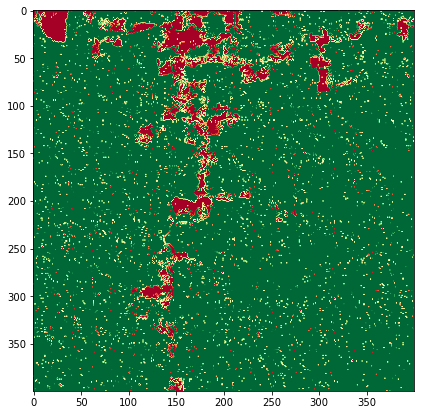

In [23]:
ndvi2017mod = ndvi2017
ndvi2017mod[ndvi2017mod < 170] = 10
ndvi2017mod[ndvi2017mod > 170] = 200
plot_image(ndvi2017mod, colmap = 'RdYlGn' )


#### Use two tones to show only regions of deforestation  in 2019

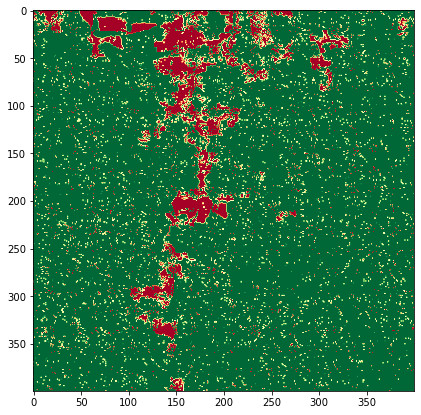

In [24]:
ndvi2019mod = ndvi2019
ndvi2019mod[ndvi2019mod < 170] = 10
ndvi2019mod[ndvi2019mod > 170] = 200
plot_image(ndvi2019mod, colmap = 'RdYlGn' )


#### Compare land area percentage of forest clearnings in 2017, 2019, and the rate of deforestation in percent of land area cleared per year.

In [25]:
len(ndvi2017mod[ndvi2017mod == 10])/len(flatten(ndvi2017mod))
#0.0886375 or 8.9% deforestation

0.0886375

In [26]:
len(ndvi2019mod[ndvi2019mod == 10])/len(flatten(ndvi2019mod))
#0.106025 or 10.6% deforestation

0.106025

In [27]:
# Percent deforested per year
(len(ndvi2019mod[ndvi2019mod == 10])/len(flatten(ndvi2019mod)) - len(ndvi2017mod[ndvi2017mod == 10])/len(flatten(ndvi2017mod))) / (2019-2017)
# 0.9% deforested per year

0.00869375